#**Harris Corner Detection and Matching**
In this report we are going to implement harris corner Detection and after that extract feature matrix to match candidate corners. in the following we explaine each part in more deatils 

##**show original images**
at first we read and show the original images :

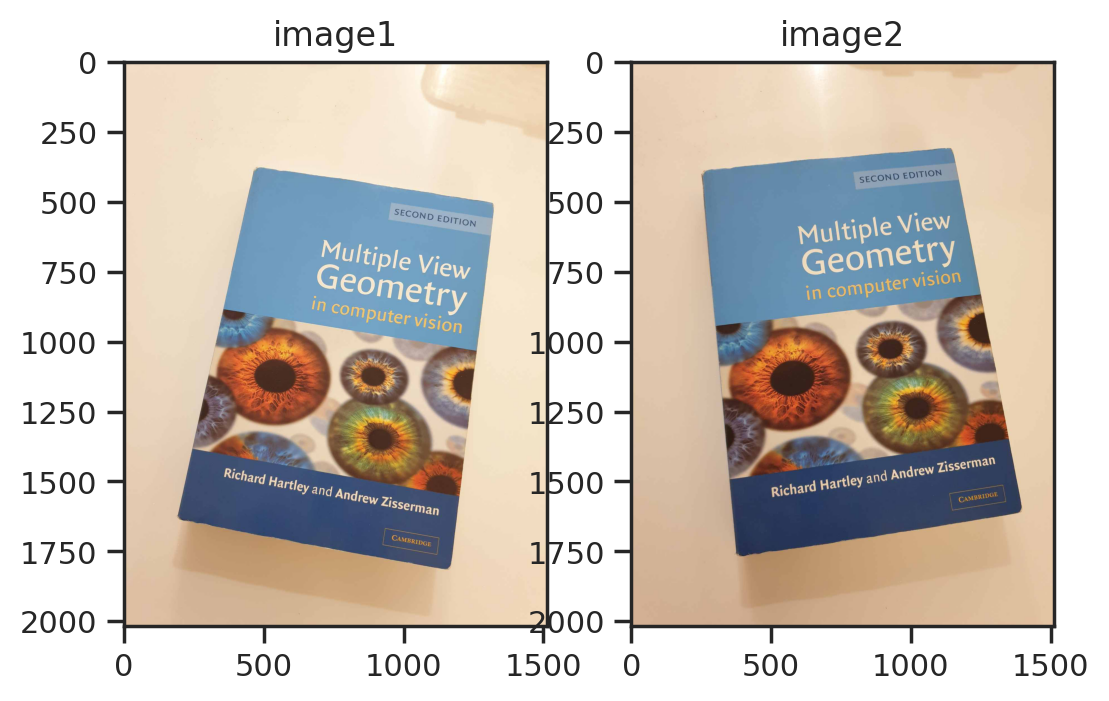

In [ ]:
import cv2 
import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

img1=plt.imread('im01.jpg').astype('float64')
img2=plt.imread('im02.jpg').astype('float64')
plt.subplot(1,2,1)
plt.imshow((img1).astype('int32'))
plt.title("image1")

plt.subplot(1,2,2)
plt.imshow((img2).astype('int32'))
plt.title("image2")
plt.show()

#blured image before calculating gradins 
blured_image = cv2.GaussianBlur(img1,(5,5),cv2.BORDER_DEFAULT)
blured_image2 = cv2.GaussianBlur(img2,(5,5),cv2.BORDER_DEFAULT)

##**Gradian calculator**
in the following i write a function for calculating gradians of image .
to calculate gradian of each channel i use `cv2.Sobel()` and set the depth of image to `CV_64F` to avoid overflow . after calculating gradian for each channel we set the gradian of image to the maximum absolute gradian of image in three channel using `np.maximum`

In [ ]:
def gradian(src):
  r,g,b=cv2.split(src)

  #gradian on x axis
  r_x=cv2.Sobel(r,cv2.CV_64F,1,0,3)
  g_x=cv2.Sobel(g,cv2.CV_64F,1,0,3)
  b_x=cv2.Sobel(b,cv2.CV_64F,1,0,3)
  grad_x=np.maximum(np.abs(r_x),np.abs(g_x),np.abs(b_x))

  #gradian on y axis
  r_y=cv2.Sobel(r,cv2.CV_64F,0,1,3)
  g_y=cv2.Sobel(g,cv2.CV_64F,0,1,3)
  b_y=cv2.Sobel(b,cv2.CV_64F,0,1,3)
  grad_y=np.maximum(np.abs(r_y),np.abs(g_y),np.abs(b_y))

  return grad_x,grad_y



##**Normilizer**
i define a function to normilize image between  [0 1]  when i want to show the images. the alogorithm is very straightforward and you can understand it by just looking at the code below : 


In [ ]:
def normilizer(src):
    return (src-np.min(src))/(np.max(src)-np.min(src))

after calculating gradians of two image we show that magnitude of gradian by the formula :  $|gradian|=\sqrt{I_{x}^2+I_{y}^2}$ . 

you can see the magnitude of gradians for both image :

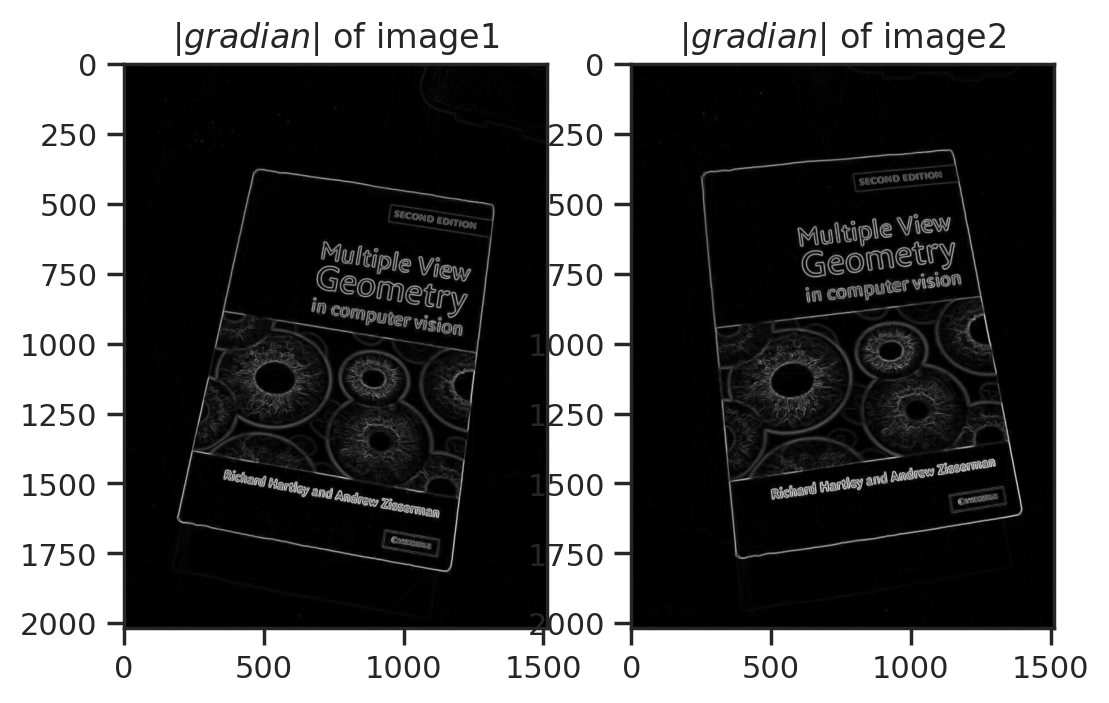

In [ ]:
ix,iy=gradian(blured_image)
mag=np.sqrt(ix**2+iy**2)

ix_2,iy_2=gradian(blured_image2)
mag_2=np.sqrt(ix_2**2+iy_2**2)

plt.subplot(1,2,1)
plt.imshow(normilizer(mag),cmap='gray')
plt.title(r'$|gradian|$ of image1')

plt.subplot(1,2,2)
plt.imshow(normilizer(mag_2),cmap='gray')
plt.title(r'$|gradian|$ of image2')

plt.show()

##**Derive Structure tensor from $S_{x}^2,S_{y}^2,S_{xy}$**
in this section we convolve gaussian filter with $I_{x}^2,I_{y}^2,I_{X}I_{y}$ using `cv2.GaussianBlur` to reach $S_{x}^2,S_{y}^2,S_{xy}$ . note that i set standard deviation and size of filter as below :

$\boxed{\sigma=4}$

$\boxed{size \  of \  kernel=17}$

Structure tensor=$\begin{bmatrix}
S_{x}^2 & S_{xy}\\
S_{xy} & S_{y}^2 
\end{bmatrix}$

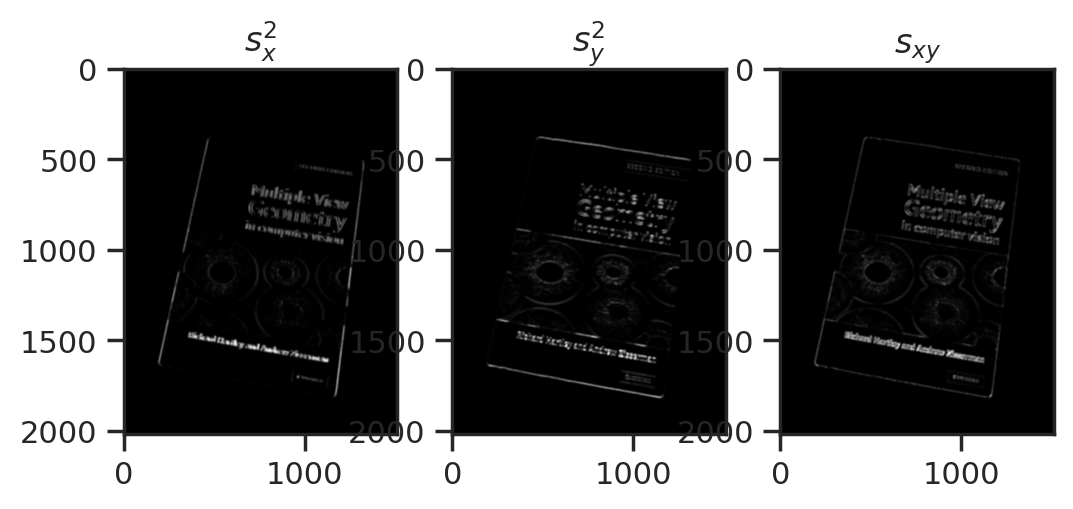

In [ ]:
sigma=4
k=17
sx2 = cv2.GaussianBlur(ix*ix,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)
sy2 = cv2.GaussianBlur(iy*iy,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)
sxy = cv2.GaussianBlur(ix*iy,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)

sx2_2 = cv2.GaussianBlur(ix_2*ix_2,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)
sy2_2 = cv2.GaussianBlur(iy_2*iy_2,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)
sxy_2 = cv2.GaussianBlur(ix_2*iy_2,(k,k),sigma,sigma,cv2.BORDER_DEFAULT)
plt.subplot(1,3,1)
plt.imshow(normilizer(sx2),cmap="gray")
plt.title(r'$s_{x}^2$')

plt.subplot(1,3,2)
plt.imshow(normilizer(sy2),cmap="gray")
plt.title(r'$s_{y}^2$')

plt.subplot(1,3,3)
plt.imshow(normilizer(sxy),cmap="gray")
plt.title(r'$s_{xy}$')

plt.show()

##**Derive Harris function**
after deriving structure tensor we calculate harris function using
following formula :

$R=det(M)-K(trace)^2$ where 

$det(M)=S_{x}^2S_{y}^2-S{xy}^2$ , $trace(M)=S_{x}^2+S_{y}^2$

after that we use proper threshold to decrease the candidates that cen be corners becuase at first we have a lots of candidates . to implement threshold, i make  a mask that has same size with images and if the pixel is below threshold it becomes 0 and if it's above threshold it becomes 1.

in this question i set $\boxed{K=0.065}$ , $\boxed{Threshhold1=0.43}$ . in the following you can see the Harris function for two images before and after threshold : 

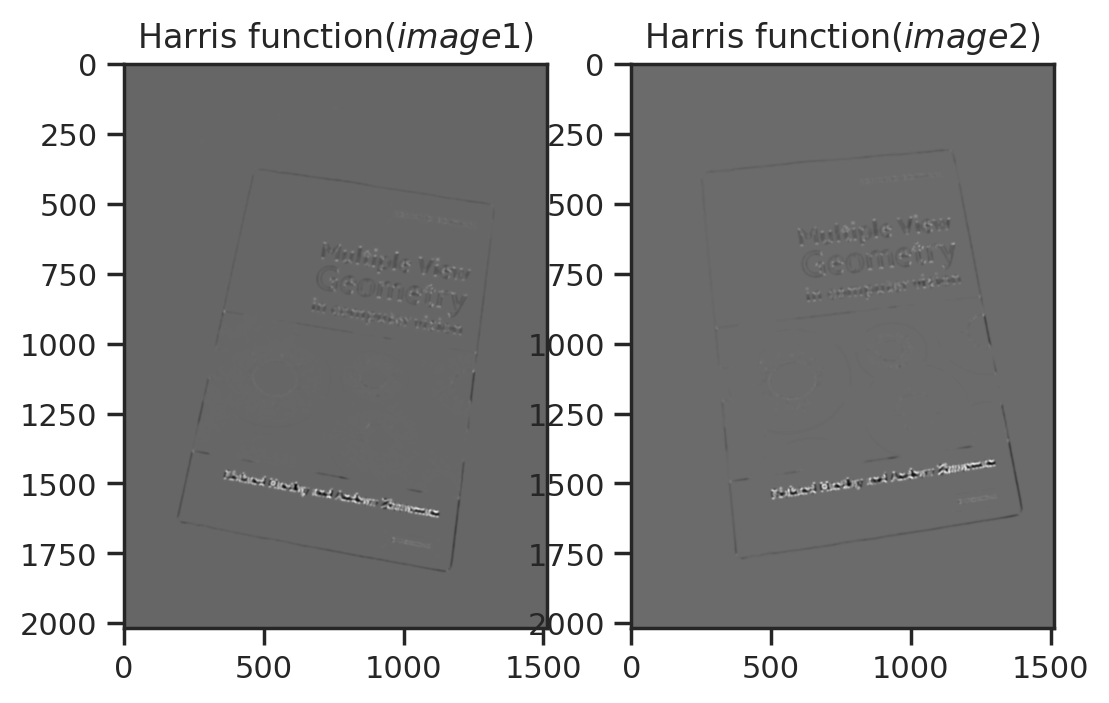

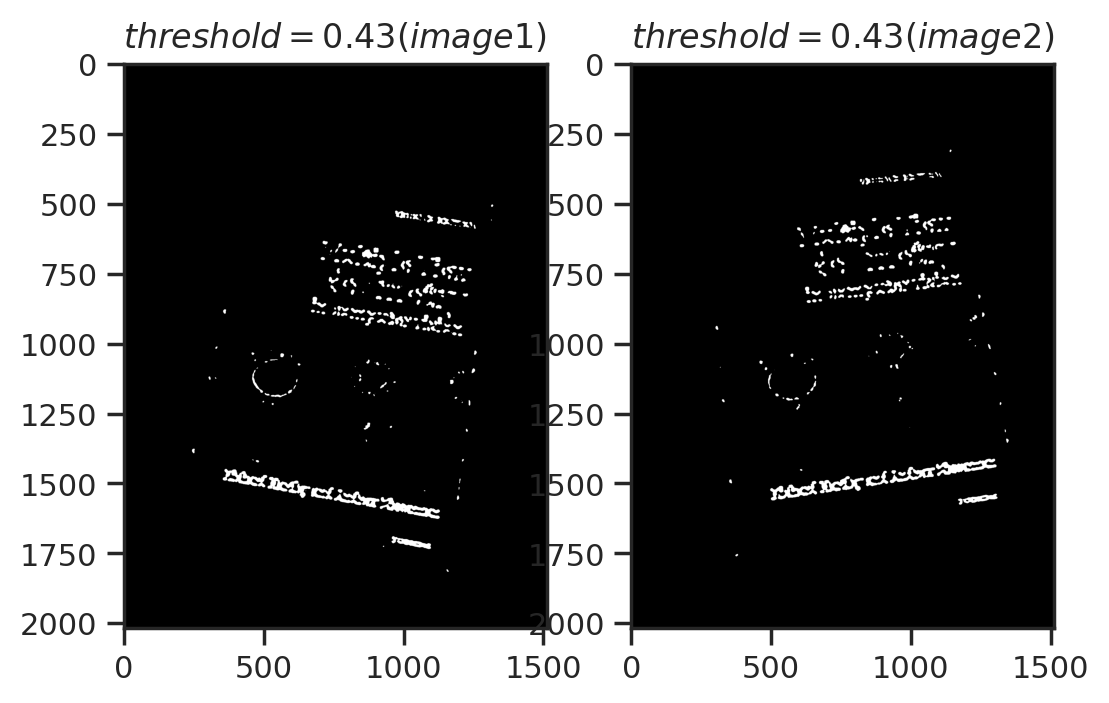

In [ ]:
det=sx2*sy2-(sxy)**2
trace=sx2+sy2

det_2=sx2_2*sy2_2-(sxy_2)**2
trace_2=sx2_2+sy2_2

k=0.065
R=det-k*(trace)**2
R2=det_2-k*(trace_2)**2

plt.subplot(1,2,1)
plt.imshow(normilizer(R),cmap="gray")
plt.title(r'Harris function$(image1)$')

plt.subplot(1,2,2)
plt.imshow(normilizer(R2),cmap="gray")
plt.title(r'Harris function$(image2)$')

plt.show()
#-------------------------
#-------------------------

norm=normilizer(R)
norm_2=normilizer(R2)
matrix=norm > 0.41
matrix_2=norm_2 > 0.43

plt.subplot(1,2,1)
plt.imshow(matrix,cmap='gray')
plt.title(r'$threshold=0.43(image1)$')

plt.subplot(1,2,2)
plt.imshow(matrix_2,cmap='gray')
plt.title(r'$threshold=0.43(image2)$')

plt.show()
plt.imsave('temp.jpg',matrix)
plt.imsave('temp_2.jpg',matrix_2)

##**NMS(non-maximum suppression)**
even after set the threshold , we can see in the harris function that pixels that are candidates to be corner are very close to each other . so beacuse of that i define a function  `nms()`. the method is very simple : we set a window with proper size (in this question the size is 10px) and then we just save the pixel with highest score and ommit all other candidates in that window . we do this procedure until that window itterate all over the image . 

In [ ]:
def nms(src):
     k=9
     result=np.copy(src)
     c1,c2=np.array(src).shape
     for i in range(k,c1-k,2*k):
         for j in range(k,c2-k,2*k):
             maximum=np.max(src[i-k:i+k,j-k:j+k])
             x,y=np.where(src[i-k:i+k,j-k:j+k]==maximum)
             result[i-k:i+k,j-k:j+k]=np.zeros([2*k,2*k])
             result[x[0]+ i,y[0]+j]=maximum

     return result                

below are harris functions after passing from nms filter :

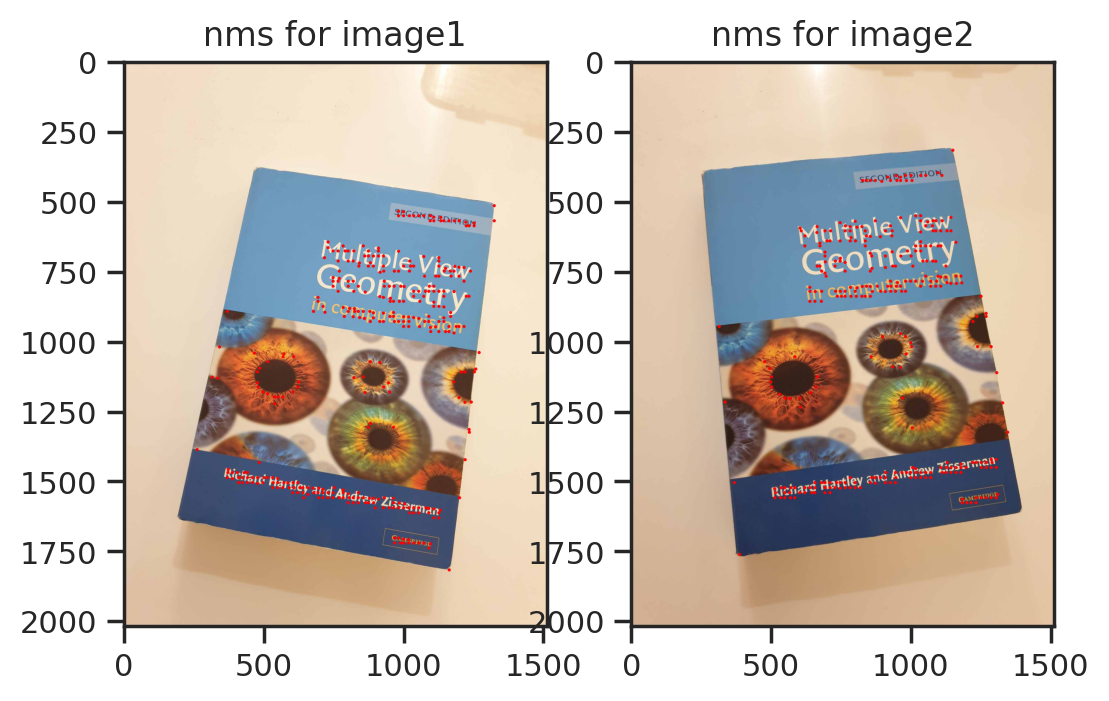

In [ ]:
nms1=nms(matrix)
nms2=nms(matrix_2)

res07=np.copy(img1)
res08=np.copy(img2)

x,y=np.where(nms1==1)
x1,y1=np.where(nms2==1)
color = (255, 0, 0)

for i in range(0,len(x)): 
    cv2.circle(res07, tuple([y[i],x[i]]), 3, color, 3)

for i in range(0,len(x1)): 
    cv2.circle(res08, tuple([y1[i],x1[i]]), 3, color, 3)


plt.subplot(1,2,1)
plt.imshow(res07.astype(np.uint8))
plt.title('nms for image1')

plt.subplot(1,2,2)
plt.imshow(res08.astype(np.uint8))
plt.title('nms for image2')

plt.show()


plt.imsave("res07_harris.jpg",res07.astype(np.uint8))
plt.imsave("res08_harris.jpg",res08.astype(np.uint8))

to show the  effect of NMS in reducing the candidates i print candidates pixels before and after NMS

In [ ]:
x,y=np.where(matrix_2==1)
print(f"number of candidates before NMS: {len(x)}")

x,y=np.where(nms2==1)
print(f"number of candidates after NMS: {len(x)}")

number of candidates before NMS: 50074
number of candidates after NMS: 311


##**Extracting feature vector for each candidate**
now, it's time to extract feature vector for corners . for each corner we choose a window with proper size($n$) centered on that corner and consider the rgb value of that window as a information that is good for feasture . so we have a tensor of information with size ($n$,$n$,$3$) for each corner. at the end we convert this tensor to array using `np.ravel()` to reach feature vector. in this question $n=80$

In [ ]:
n=80
feature_vector1=[]
feature_vector2=[]

x_image1,y_image1=np.where(nms1==1)
x_image2,y_image2=np.where(nms2==1)

for i in range(0,len(x_image1)):
      tensor_feature=img1[x_image1[i]-n:x_image1[i]+n,y_image1[i]-n:y_image1[i]+n,:]
      vector=np.ravel(tensor_feature)
      feature_vector1.append(vector)

for j in range(0,len(x_image2)):
      tensor_feature2=img2[x_image2[j]-n:x_image2[j]+n,y_image2[j]-n:y_image2[j]+n,:]
      vector=np.ravel(tensor_feature2)
      feature_vector2.append(vector) 



##**Find corresponding points**
to find corresponding points , for each corner in image 1 we have to find two nearest corners in image2 and vice versa.so i define `find_two_max()` function that find the two nerarest corners in images . in this function we itterate all over the image using `brute force` method. also we have to specify that which definition we use to compute distance between corners. in this question $\boxed{i \ use  \ L_{2}  \ distance}$ . that is for two vectors $u$ and $v$ that their dimensions are $(1,n^{2})$ we have :$\boxed{L_{2}(u,v)=\sqrt[2]{\sum^{n^{2}}_{i=1}|u_{i}-v_{i}|^{2}}}$


In [ ]:
def find_two_max(feature1,feature2):

    ratio_im1=[]
    index_im1=[]
    ratio_im2=[]
    index_im2=[]

    #first part 
    for i in range(0,len(feature1)):
         min_value_first=1e20
         min_value_second=1e20
         min_index=0
         for j in range(0,len(feature2)):
              dis=np.linalg.norm(feature1[i]-feature2[j])
              if(dis<min_value_first):
                  min_value_second=min_value_first
                  min_value_first=dis
                  min_index=j
                  dis-=1
              if(min_value_first<=dis<min_value_second):
                  min_value_second=dis   
         ratio=float(min_value_first/min_value_second)              
         ratio_im1.append(ratio)
         index_im1.append(min_index)

    #second part 
    for i in range(0,len(feature2)):
         min_value_first=1e20
         min_value_second=1e20
         min_index=0
         for j in range(0,len(feature1)):
              dis=np.linalg.norm(feature2[i]-feature1[j])
              if(dis<min_value_first):
                  min_value_second=min_value_first
                  min_value_first=dis
                  min_index=j
                  dis-=1
              if(min_value_first<=dis<min_value_second):
                  min_value_second=dis   
         ratio=float(min_value_first/min_value_second)              
         ratio_im2.append(ratio)
         index_im2.append(min_index)         
       
    return ratio_im1,index_im1,ratio_im2,index_im2


##**Rules for  corresponding pairs**
after finding two nearest corners in two image , we have to filter them based on three following rules :

 * we have to set the threshold for ratio between first and second nearest corresponding for each corner . that is :

$r$= $\frac{L_{2}(first \ corresponding)}{L_{2}(second \ corresponding)} \leqslant Threshold$ 

 $i \ set \ this \ Threshold \ to \ 0.95 \ in \ this \ question$

 * if $B$ is the corresponding point for corner $A$  , $A$ should be corresponding point for $B$ too 
 * if a corner is corresponding points for more than one corner in other image , we have to omit that corner from list of corresponding pairs 


In [ ]:
rt1,ind1,rt2,ind2=find_two_max(feature_vector1,feature_vector2)

#pass from Threshold filter
index1=np.where(np.array(rt1)<(0.96))
index2=np.where(np.array(rt2)<(0.96))
same_index=[]
final_index=[]

#implement the rules above to find corresponding pairs
for i in range(0,int(np.array(index1).shape[1])):
      j= ind1[int(np.array(index1)[0,i])]
      if(ind2[j]==(np.array(index1)[0,i]) and j not in same_index):
          final_index.append((np.array(index1)[0,i]))
          same_index.append(j)

##**show final results**

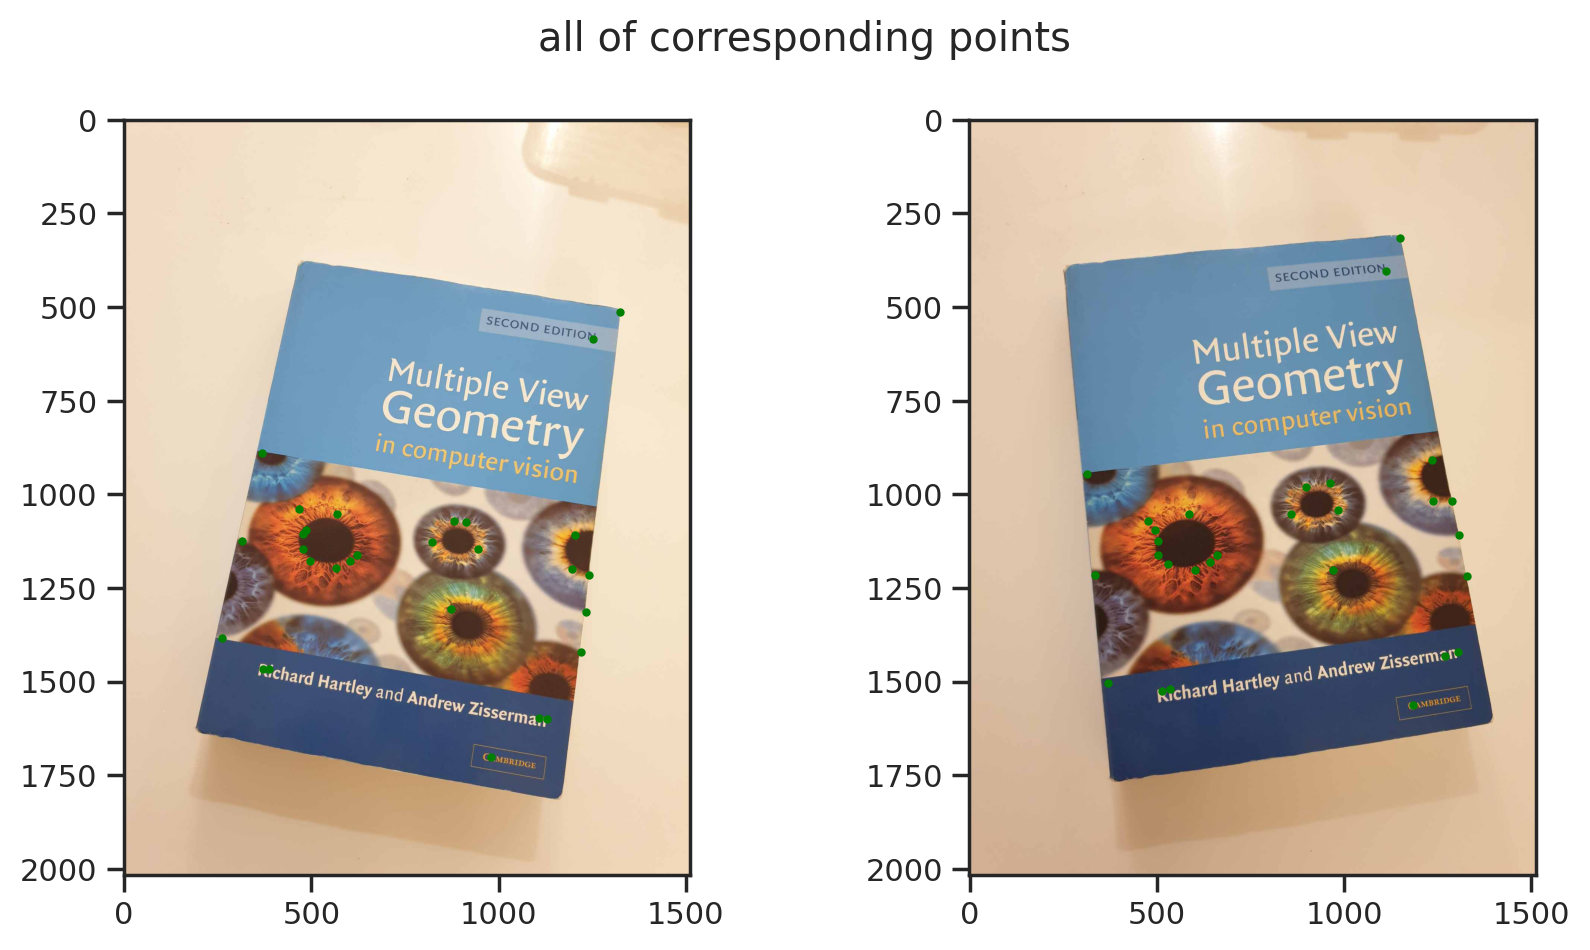

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img1.astype('int32'))
ax2.imshow(img2.astype('int32'))
for i in range(len(final_index)):
  number=int(final_index[i])
  j=ind1[number]
  ax1.plot(y_image1[number],x_image1[number],'ro',markersize=2,color='green')
  ax2.plot(y_image2[j],x_image2[j],'ro',markersize=2,color='green')

plt.savefig("khkhk.jpg")
plt.suptitle(r"all of corresponding points")
plt.show()


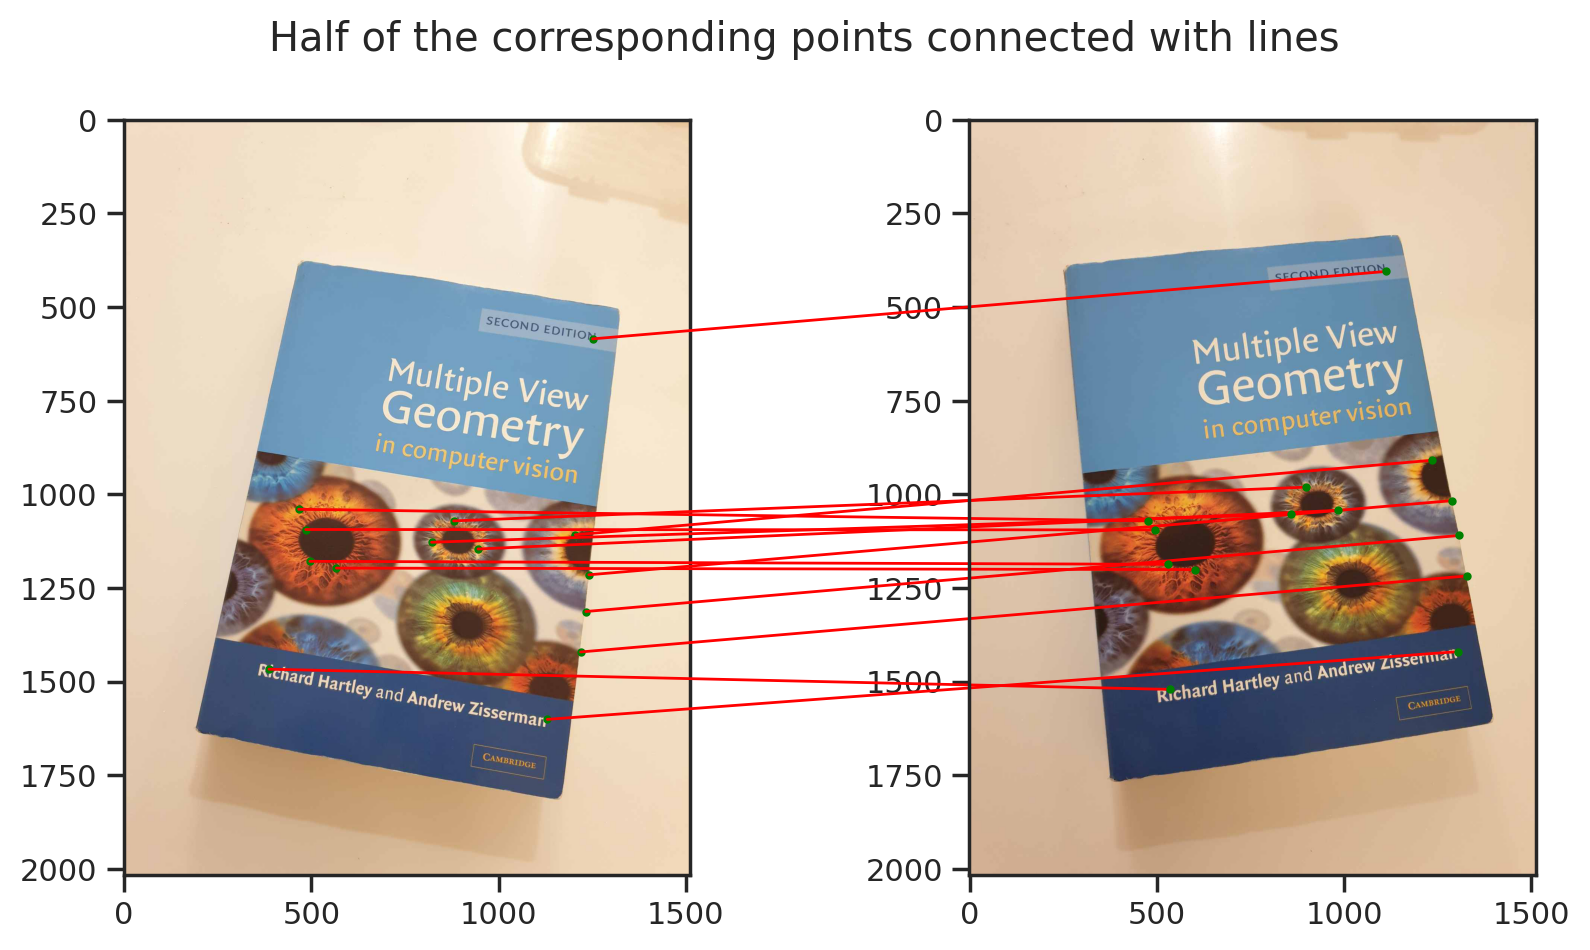

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img1.astype('int32'))
ax2.imshow(img2.astype('int32'))
for i in range(1,len(final_index),2):
  number=int(final_index[i])
  j=ind1[number]
  xy = (y_image1[number],x_image1[number])
  xy1= (y_image2[j],x_image2[j])
  con = ConnectionPatch(xyA=xy, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="red")
  ax2.add_artist(con)
  ax1.plot(y_image1[number],x_image1[number],'ro',markersize=2,color='green')
  ax2.plot(y_image2[j],x_image2[j],'ro',markersize=2,color='green')

plt.savefig("res11.jpg")
plt.suptitle(r"Half of the corresponding points connected with lines")
plt.show()

##**Parameters**
$1) \ standard  \ deviation = \sigma=4$

$2) \ size \ of  \ guassian \ filter=17$

$3) \ K=0.065$

$4) \ N(size \ of \ window \ for \ feature \ vector)=80 \ pixel$

$5) \ Type \  of  \ distance  \ function=L_{2} \ norm$

$6) \ threshold1( used \ for \ res05 \ and \ res06)=0.43$

$7) \ threshold2(threshold \ for \ the \ ratio \ of \ d_{1} \ and  \ d{2})=0.95$